# Часть 1. Классификация

### Многоклассовая классификация

Если просто брать целые фотографии 6000х4000 пикселей, то это ни к чему хорошему не приведёт. Так как такая картинка содержит очень много информации, объектов - это всё может сбивать нейросеть с толку. Поэтому было решено вручную нарезать фотографии по 1024х1024 и уже в таком виде подавать на вход нейросети.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


classes.zip содержит нарезанные фотографии

In [ ]:
!unzip "/content/drive/My Drive/classes.zip"

Создаём папки train и val

In [42]:
import shutil 
from tqdm.notebook import tqdm
import os

data_root = './'
train_dir = 'train'
val_dir = 'val'

for dir_name in [train_dir, val_dir]:
    for class_name in os.listdir('classes'):
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

In [43]:
a = []

for class_name in os.listdir('classes'):
    source_dir = os.path.join(data_root, 'classes', class_name)
    for i, file_name in enumerate(os.listdir(source_dir)):
        a.append([file_name, os.path.join(source_dir, file_name), class_name])

Создаём датафрейм, содержащий пути до файлов и классы

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split as split

df = pd.DataFrame(a, columns=['file_name', 'img_path', 'class'])

Распределение классов. Частые классы были убраны, чтобы избежать дисбаланс. Это явление также можно было обойти, выдавая классам веса

In [44]:
df['class'].value_counts()

holes       52
trash       50
no_leaks    50
leaks       48
trans       33
Name: class, dtype: int64

Делим данные на тренировочную и валидационную выборку

In [45]:
df_train, df_test = split(df, test_size=0.2, random_state=42, stratify=df['class'])

Копируем в папки train и val соответствующие фотографии

In [46]:
df_train.apply(lambda x: shutil.copy(x['img_path'], os.path.join(train_dir, x['class'], x['file_name'])), axis=1)

33         train/leaks/oil_12.jpg
68       train/trans/trans_22.jpg
470        train/trash/rub_48.jpg
21        train/leaks/oil_317.jpg
507        train/trash/rub_51.jpg
                  ...            
493        train/trash/rub_32.jpg
472        train/trash/rub_64.jpg
453        train/trash/rub_69.jpg
128       train/holes/hole_38.jpg
181    train/no_leaks/oil_126.jpg
Length: 186, dtype: object

In [ ]:
df_test.apply(lambda x: shutil.copy(x['img_path'], os.path.join(val_dir, x['class'], x['file_name'])), axis=1)

Объявляем аугментации: приведение к размеру 224х224, случайные повороты. Также создаём даталоадеры

In [53]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)


train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=16)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16, shuffle=False, num_workers=16)

In [54]:
class_names = train_dataset.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Посмотрим, как выглядят классы

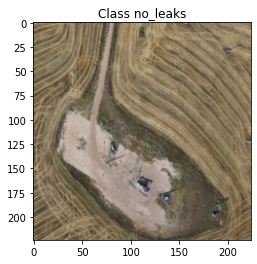

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


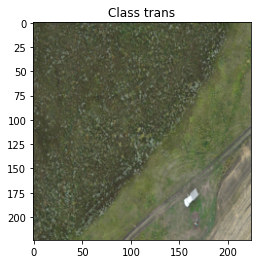

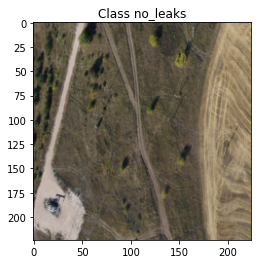

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


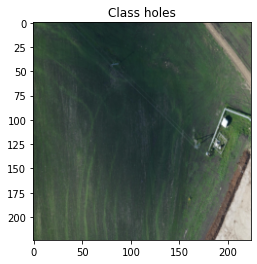

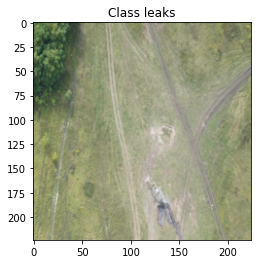

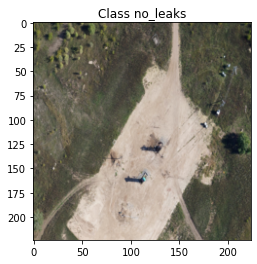

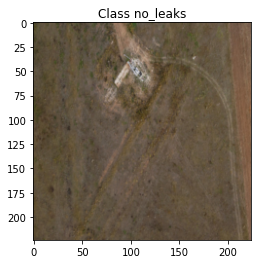

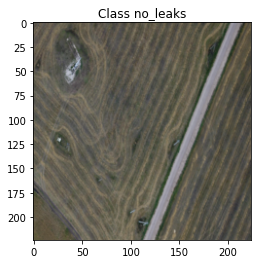

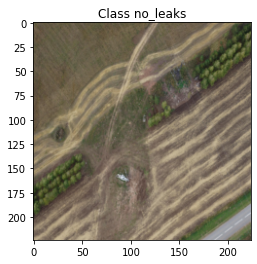

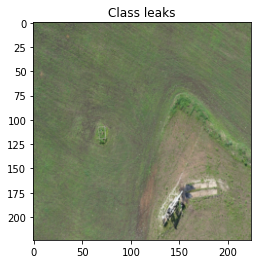

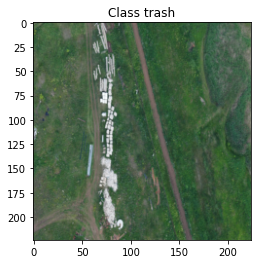

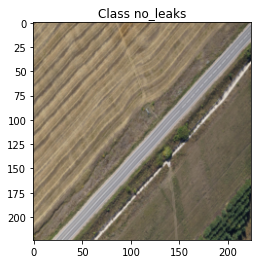

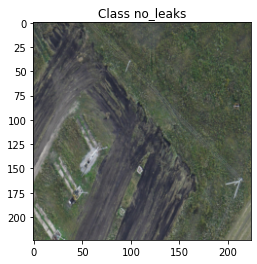

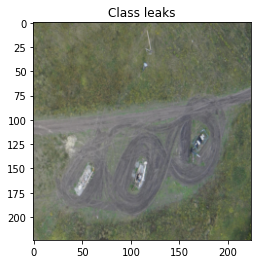

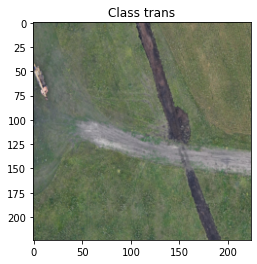

In [74]:
batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for X_batch, y_batch in zip(*batch):
  plt.title('Сlass {}'.format(class_names[y_batch.item()]))
  plt.imshow(X_batch.permute(1, 2, 0).numpy() * std + mean)
  plt.show();

Функция с циклом обучения

In [75]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)


        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train() 
            else:
                dataloader = val_dataloader
                model.eval() 

            running_loss = 0.
            running_acc = 0.


            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)


                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()


                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().sum()

            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(train_dataset if phase=='train' else val_dataset)
            scheduler.step()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

Будем пользоваться предобученной моделью resnet18. Добавим слои дропаута, батчнорма и выходной слой

In [76]:
from torch import nn

model = models.resnet18(pretrained=True)

model.fc = nn.Sequential(
    nn.Dropout(),
    nn.BatchNorm1d(model.fc.in_features),
    nn.Linear(model.fc.in_features, len(class_names)),
)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [77]:
loss = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [80]:
train_model(model, loss, optimizer, scheduler, num_epochs=10);

Epoch 0/9:
train Loss: 0.6104 Acc: 0.7366
val Loss: 0.5958 Acc: 0.7447
Epoch 1/9:
train Loss: 0.3850 Acc: 0.8065
val Loss: 0.5322 Acc: 0.7447
Epoch 2/9:
train Loss: 0.2691 Acc: 0.8602
val Loss: 0.6052 Acc: 0.7872
Epoch 3/9:
train Loss: 0.2724 Acc: 0.8548
val Loss: 0.6287 Acc: 0.7660
Epoch 4/9:
train Loss: 0.2151 Acc: 0.9140
val Loss: 0.5422 Acc: 0.8298
Epoch 5/9:
train Loss: 0.1308 Acc: 0.9301
val Loss: 0.4665 Acc: 0.8085
Epoch 6/9:
train Loss: 0.1428 Acc: 0.9409
val Loss: 0.5166 Acc: 0.7660
Epoch 7/9:
train Loss: 0.1157 Acc: 0.9570
val Loss: 0.5349 Acc: 0.7660
Epoch 8/9:
train Loss: 0.0994 Acc: 0.9677
val Loss: 0.4950 Acc: 0.7872
Epoch 9/9:
train Loss: 0.0979 Acc: 0.9570
val Loss: 0.5150 Acc: 0.7660


In [81]:
class_correct = list(0. for i in range(len(class_names)))
class_total = list(0. for i in range(len(class_names)))
model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(X_batch)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == y_batch).squeeze()
        for i in range(len(y_pred)):
            label = y_batch[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(len(class_names)):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

Accuracy of holes : 90 %
Accuracy of leaks : 70 %
Accuracy of no_leaks : 50 %
Accuracy of trans : 100 %
Accuracy of trash : 80 %


Таким образом, мы получили хорошие результаты. Можно заметить, что точность предсказания класса скважины без разливов (no_leaks) составила 50%. Его можно повысить, если добавить больше примеров со скважинами без разливов нефти (так как мы взяли меньше экземпляров этого класса).

### Бинарная классификация

Как дополнение попробуем научиться отличать скважины с разливами от скважин без разливов. Распакуем архив, содержащий фотографии со скважинами без разливов, а также фотографии разливов нефти

In [ ]:
!unzip "drive/My Drive/train.zip" -d data

Archive:  drive/My Drive/train.zip
  inflating: data/no_razliv_new/Скважины без разливов (1).JPG  
  inflating: data/no_razliv_new/Скважины без разливов (11).JPG  
  inflating: data/no_razliv_new/Скважины без разливов (14).JPG  
  inflating: data/no_razliv_new/Скважины без разливов (18).JPG  
  inflating: data/no_razliv_new/Скважины без разливов (2).JPG  
  inflating: data/no_razliv_new/Скважины без разливов (20).JPG  
  inflating: data/no_razliv_new/Скважины без разливов (22).JPG  
  inflating: data/no_razliv_new/Скважины без разливов (25).JPG  
  inflating: data/no_razliv_new/Скважины без разливов (26).JPG  
  inflating: data/no_razliv_new/Скважины без разливов (28).JPG  
  inflating: data/no_razliv_new/Скважины без разливов (3).JPG  
  inflating: data/no_razliv_new/Скважины без разливов (30).JPG  
  inflating: data/no_razliv_new/Скважины без разливов (34).JPG  
  inflating: data/no_razliv_new/Скважины без разливов (36).JPG  
  inflating: data/no_razliv_new/Скважины без разливов (4).

In [ ]:
import shutil 
from tqdm.notebook import tqdm
import os

data_root = './'
train_dir = 'train'
val_dir = 'val'

class_names = ['razliv_new', 'no_razliv_new']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'data', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 5 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

BS = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BS, shuffle=True, num_workers=BS)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=8, shuffle=False, num_workers=8)

In [ ]:
from torch import nn

model = models.resnet18(pretrained=True)

model.fc = nn.Sequential(
    nn.Dropout(),
    nn.BatchNorm1d(model.fc.in_features),
    nn.Linear(model.fc.in_features, 2),
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:
train Loss: 0.7880 Acc: 0.4714
val Loss: 0.9216 Acc: 0.2045
Epoch 1/99:
train Loss: 0.4834 Acc: 0.7829
val Loss: 1.5285 Acc: 0.4333
Epoch 2/99:
train Loss: 0.5410 Acc: 0.7583
val Loss: 0.8964 Acc: 0.7500
Epoch 3/99:
train Loss: 0.4212 Acc: 0.7740
val Loss: 1.0438 Acc: 0.8770
Epoch 4/99:
train Loss: 0.2431 Acc: 0.8656
val Loss: 0.5463 Acc: 0.8770
Epoch 5/99:
train Loss: 0.1336 Acc: 1.0000
val Loss: 0.4616 Acc: 0.8770
Epoch 6/99:
train Loss: 0.2540 Acc: 0.8628
val Loss: 0.2581 Acc: 0.8770
Epoch 7/99:
train Loss: 0.1937 Acc: 0.9417
val Loss: 0.2425 Acc: 0.8770
Epoch 8/99:
train Loss: 0.1330 Acc: 1.0000
val Loss: 0.1922 Acc: 0.8770
Epoch 9/99:
train Loss: 0.2308 Acc: 0.9380
val Loss: 0.1684 Acc: 0.8770
Epoch 10/99:
train Loss: 0.1504 Acc: 0.9276
val Loss: 0.1509 Acc: 0.8770
Epoch 11/99:
train Loss: 0.1423 Acc: 0.9704
val Loss: 0.1719 Acc: 0.8770
Epoch 12/99:
train Loss: 0.3954 Acc: 0.8720
val Loss: 0.1744 Acc: 0.8770
Epoch 13/99:
train Loss: 0.1195 Acc: 1.0000
val Loss: 0.1917 

Получаем 100% на тренировочной выборке и 87.7% на валидации. Посмотрим на предсказания на валидации; указаны вероятность класса (1 - разлив нефти), а также реальный класс

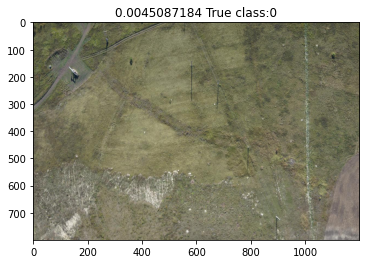

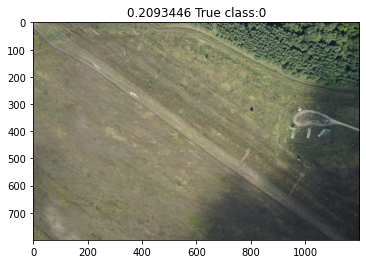

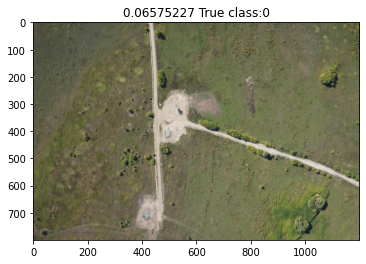

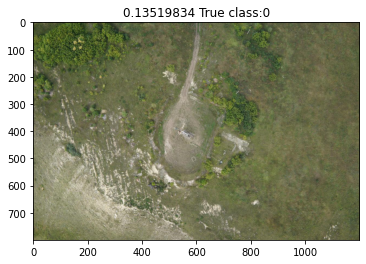

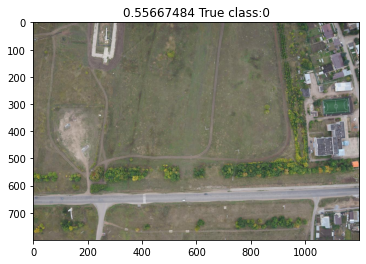

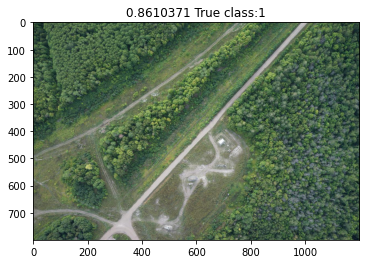

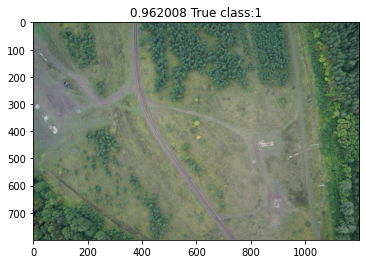

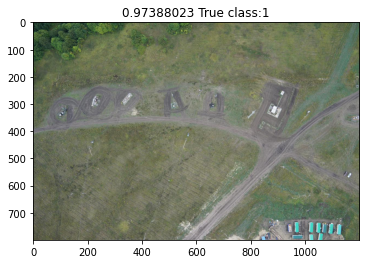

In [ ]:
inputs, labels = next(iter(val_dataloader))

for num, (img, pred) in enumerate(zip(inputs, test_predictions)):
    show_input(img, title=str(pred)+' True class:' + str(labels[num].item()))

Можем увидеть, что нейросеть хорошо классифицирует объекты на фотографиях. Но фотографии очень большие и нельзя сразу увидеть, где был обнаружен тот или иной объект - это доставит неудобства, если внедрять модель в продакшн. Было бы хорошо научить нейросеть выделять на фотографии области, в которых находится какая-то аномалия. Решим задачу семантической сегментации (Часть 2)